# Project Title

**Authors:** Carlos McCrum, Micheal Lee, Doug Mill
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler, label_binarize
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import CategoricalNB

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [2]:
df1 = pd.read_csv('Traffic_Crashes_-_Crashes.csv')

In [3]:
df2 = pd.read_csv('Traffic_Crashes_-_Vehicles.csv')

In [4]:
df3 = pd.read_csv('Traffic_Crashes_-_People.csv')

In [5]:
df_crash = df1.copy()
df_vehicle = df2.copy()
df_people = df3.copy()

***
# Cleaning Crashes

In [6]:
# drop 'CRASH_DATE_EST_I', 'LANE_CNT', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I',
# 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I'

not_relevant_info = ['RD_NO', 'CRASH_DATE', 'CRASH_DATE_EST_I', 'LANE_CNT', 'REPORT_TYPE', 'CRASH_TYPE', \
                  'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'DATE_POLICE_NOTIFIED', 'DAMAGE', 'NUM_UNITS', \
                  'HIT_AND_RUN_I', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'FIRST_CRASH_TYPE', \
                  'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'ALIGNMENT', \
                  'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', \
                  'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', \
                  'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', \
                  'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', \
                  'LATITUDE', 'LONGITUDE', 'LOCATION', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'POSTED_SPEED_LIMIT'
                 ]

df_crash.drop((not_relevant_info), axis = 1, inplace = True)
df_crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554228 entries, 0 to 554227
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   CRASH_RECORD_ID          554228 non-null  object
 1   TRAFFIC_CONTROL_DEVICE   554228 non-null  object
 2   DEVICE_CONDITION         554228 non-null  object
 3   WEATHER_CONDITION        554228 non-null  object
 4   LIGHTING_CONDITION       554228 non-null  object
 5   TRAFFICWAY_TYPE          554228 non-null  object
 6   ROADWAY_SURFACE_COND     554228 non-null  object
 7   ROAD_DEFECT              554228 non-null  object
 8   PRIM_CONTRIBUTORY_CAUSE  554228 non-null  object
 9   SEC_CONTRIBUTORY_CAUSE   554228 non-null  object
dtypes: object(10)
memory usage: 42.3+ MB


In [7]:
relevant_device_present = ['TRAFFIC SIGNAL', 'STOP SIGN/FLASHER', 'OTHER', 'LANE USE MARKING', 'YIELD', 'OTHER REG. SIGN', \
                 'OTHER WARNING SIGN', 'RAILROAD CROSSING GATE', 'PEDESTRIAN CROSSING SIGN', 'POLICE/FLAGMAN', 'SCHOOL ZONE', \
                 'DELINEATORS', 'FLASHING CONTROL SIGNAL', 'BICYCLE CROSSING SIGN', 'NO PASSING', 'RR CROSSING SIGN']

def traffic_control_transfomer(val):
    if val in relevant_device_present:
        return 1
    else:
        return 0

df_crash['TRAFFIC_DEVICE_PRESENT'] = df_crash['TRAFFIC_CONTROL_DEVICE'].map(traffic_control_transfomer)

In [8]:
working_devices = ['FUNCTIONING PROPERLY', 'WORN REFLECTIVE MATERIAL']

def device_working(val):
    if val in working_devices:
        return 1
    else:
        return 0
    
df_crash['DEVICE_WORKING'] = df_crash['DEVICE_CONDITION'].map(device_working)

In [9]:
def device_present(val):
    if val == True:
        return 1
    else:
        return 0

In [10]:
device_list = (df_crash['TRAFFIC_DEVICE_PRESENT'] == 1) & (df_crash['DEVICE_WORKING'] == 1)
device_dataframe = pd.DataFrame(device_list, columns = ['TRAFFIC_DEVICE'], index = df_crash.index)
frames = [df_crash, device_dataframe]
df_crash = pd.concat(frames, axis = 1)

In [11]:
df_crash['TRAFFIC_DEVICE'] = df_crash['TRAFFIC_DEVICE'].map(device_present)

In [12]:
bad_weather_cond = ['RAIN', 'SNOW', 'FOG/SMOKE/HAZE', 'SLEET/HAIL', 'FREEZING RAIN/DRIZZLE', 'BLOWING SNOW', \
                   'SEVERE CROSS WIND GATE', 'BLOWING SAND, SOIL, DIRT']

def weather_condition(val):
    if val in bad_weather_cond:
        return 1
    else:
        return 0
    
df_crash['BAD_WEATHER'] = df_crash['WEATHER_CONDITION'].map(weather_condition)

In [13]:
bad_visibility = ['DARKNESS', 'DUSK', 'DAWN']

def visibility(val):
    if val in bad_visibility:
        return 1
    else:
        return 0

df_crash['BAD_VISIBILITY'] = df_crash['LIGHTING_CONDITION'].map(visibility)

In [14]:
def trafficway_danger(val):
    if val == 'NOT DIVIDED':
        return 1
    else:
        return 0
    
df_crash['BAD_TRAFFIC'] = df_crash['TRAFFICWAY_TYPE'].map(trafficway_danger)

In [15]:
bad_road_cond = ['WET', 'SNOW OR SLUSH', 'ICE', 'SAND, MUD, DIRT']

def road_cond(val):
    if val in bad_road_cond:
        return 1
    else:
        return 0
    
df_crash['BAD_ROAD_CONDITION'] = df_crash['ROADWAY_SURFACE_COND'].map(road_cond)

In [16]:
road_defect = ['RUT, HOLES', 'WORN_SURFACE']

def defect_road(val):
    if val in road_defect:
        return 1
    else:
        return 0

df_crash['DEFECT_ROAD'] = df_crash['ROAD_DEFECT'].map(defect_road)

In [17]:
driving = ['FAILING TO YIELD RIGHT-OF-WAY', 'FOLLOWING TOO CLOSELY', 'IMPROPER OVERTAKING/PASSING', 'FAILING TO REDUCE SPEED TO AVOID CRASH', \
          'IMPROPER BACKING', 'IMPROPER LANE USAGE', 'IMPROPER TURNING/NO SIGNAL', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE', \
          'DISREGARDING TRAFFIC SIGNALS', 'DISREGARDING STOP SIGN', 'DISTRACTION - FROM INSIDE VEHICLE', 'DRIVING ON WRONG SIDE/WRONG WAY', \
          'DISTRACTION - FROM OUTSIDE VEHICLE', 'EXCEEDING AUTHORIZED SPEED LIMIT', 'EXCEEDING SAFE SPEED FOR CONDITIONS', \
          'DISREGARDING OTHER TRAFFIC SIGNS', 'DISREGARDING ROAD MARKINGS', 'TURNING RIGHT ON RED', 'RELATED TO BUS STOP', 'DISREGARDING YIELD SIGN', \
          'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)', 'PASSING STOPPED SCHOOL BUS']
behavior = ['PHYSICAL CONDITION OF DRIVER', 'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER' \
           'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)', 'CELL PHONE USE OTHER THAN TEXTING', \
           'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)', 'TEXTING']
road = ['WEATHER', 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)', 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS', \
       'ROAD CONSTRUCTION/MAINTENANCE']
other = ['EQUIPMENT - VEHICLE CONDITION', 'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST', 'ANIMAL', \
         'BICYCLE ADVANCING LEGALLY ON RED LIGHT', 'OBSTRUCTED CROSSWALKS', 'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT']


In [18]:
for index, row in df_crash.iterrows(): 
    if df_crash.loc[index,'PRIM_CONTRIBUTORY_CAUSE'] == 'UNABLE TO DETERMINE':
        if (df_crash.loc[index,'SEC_CONTRIBUTORY_CAUSE'] != 'UNABLE TO DETERMINE') & (df_crash.loc[index,'SEC_CONTRIBUTORY_CAUSE'] != 'NOT APPLICABLE'):
            df_crash.loc[index,'PRIM_CONTRIBUTORY_CAUSE'] = df_crash.loc[index,'SEC_CONTRIBUTORY_CAUSE']

In [19]:
def crash_cause(val):
    if val in driving:
        return 1
    elif val in behavior:
        return 2
    elif val in road:
        return 3
    else:
        return 4

df_crash['Target1'] = df_crash['PRIM_CONTRIBUTORY_CAUSE'].map(crash_cause)

In [20]:
unnecessary_traffic_columns = ['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'TRAFFIC_DEVICE_PRESENT', 'DEVICE_WORKING', \
                              'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', \
                              'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE']
df_crash.drop(unnecessary_traffic_columns, axis = 1, inplace = True)

In [21]:
df_crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554228 entries, 0 to 554227
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   CRASH_RECORD_ID     554228 non-null  object
 1   TRAFFIC_DEVICE      554228 non-null  int64 
 2   BAD_WEATHER         554228 non-null  int64 
 3   BAD_VISIBILITY      554228 non-null  int64 
 4   BAD_TRAFFIC         554228 non-null  int64 
 5   BAD_ROAD_CONDITION  554228 non-null  int64 
 6   DEFECT_ROAD         554228 non-null  int64 
 7   Target1             554228 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 33.8+ MB


***
# Cleaning People

In [22]:
df_people.drop(['PERSON_ID', 'PERSON_TYPE', 'RD_NO', 'VEHICLE_ID', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 
         'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION', 
         'INJURY_CLASSIFICATION', 'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 
         'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE', 'CELL_PHONE_USE'], axis=1, inplace=True)
df_people.columns

Index(['CRASH_RECORD_ID', 'CRASH_DATE', 'AGE', 'DRIVER_ACTION',
       'DRIVER_VISION', 'PHYSICAL_CONDITION'],
      dtype='object')

In [23]:
#Drop missing and null values
df_people.dropna(subset=['AGE'], inplace=True)
df_people.dropna(subset=['DRIVER_ACTION'], inplace=True)
df_people.dropna(subset=['DRIVER_VISION'], inplace=True)
df_people.dropna(subset=['PHYSICAL_CONDITION'], inplace=True)

In [24]:
#Cleaning the 3 columns with many unknown values
df_people = df_people[df_people['DRIVER_VISION']!='UNKNOWN']
df_people = df_people[df_people['DRIVER_ACTION']!='UNKNOWN']
df_people = df_people[df_people['PHYSICAL_CONDITION']!='UNKNOWN']

In [25]:
#Formatting, cleaning, and binning the AGE column. 15 is the youngest age to legally drive in the state of Illinois
#with a learner's permit. 
df_people = df_people[df_people['AGE']>=10]
bins = [9, 14, 19, 29, 39, 49, 59, 69, np.inf]
names = ['Underage 10-14', '15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
df_people['AGE_RANGES'] = pd.cut(df_people['AGE'], bins, labels=names)
print(df_people['AGE_RANGES'].value_counts())
# df.drop('AGE', axis=1, inplace=True)

20-29             116624
30-39             105008
40-49              82265
50-59              69003
60-69              41753
70+                18967
15-19              16790
Underage 10-14       645
Name: AGE_RANGES, dtype: int64


In [26]:
#value counts of underage drivers between 10-15. 9 and under deleted.
df_people[df_people['AGE_RANGES']=='Underage 10-14']['AGE'].value_counts()

14.0    242
13.0    132
12.0     93
11.0     92
10.0     86
Name: AGE, dtype: int64

In [27]:
df_people.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451055 entries, 1 to 1224557
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   CRASH_RECORD_ID     451055 non-null  object  
 1   CRASH_DATE          451055 non-null  object  
 2   AGE                 451055 non-null  float64 
 3   DRIVER_ACTION       451055 non-null  object  
 4   DRIVER_VISION       451055 non-null  object  
 5   PHYSICAL_CONDITION  451055 non-null  object  
 6   AGE_RANGES          451055 non-null  category
dtypes: category(1), float64(1), object(5)
memory usage: 24.5+ MB


***
# Cleaning Vehicles

In [28]:
df_vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134612 entries, 0 to 1134611
Data columns (total 72 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   CRASH_UNIT_ID             1134612 non-null  int64  
 1   CRASH_RECORD_ID           1134612 non-null  object 
 2   RD_NO                     1125395 non-null  object 
 3   CRASH_DATE                1134612 non-null  object 
 4   UNIT_NO                   1134612 non-null  int64  
 5   UNIT_TYPE                 1132985 non-null  object 
 6   NUM_PASSENGERS            169810 non-null   float64
 7   VEHICLE_ID                1108583 non-null  float64
 8   CMRC_VEH_I                20992 non-null    object 
 9   MAKE                      1108578 non-null  object 
 10  MODEL                     1108435 non-null  object 
 11  LIC_PLATE_STATE           1011371 non-null  object 
 12  VEHICLE_YEAR              928020 non-null   float64
 13  VEHICLE_DEFECT            1

In [29]:
df_vehicle = df_vehicle[['CRASH_RECORD_ID', 'NUM_PASSENGERS', 'MAKE', 'MODEL', 'VEHICLE_DEFECT']]

In [30]:
df_vehicle.dropna(subset=['MODEL', 'MAKE', 'NUM_PASSENGERS'], inplace=True)
df_vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169780 entries, 7 to 1134600
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CRASH_RECORD_ID  169780 non-null  object 
 1   NUM_PASSENGERS   169780 non-null  float64
 2   MAKE             169780 non-null  object 
 3   MODEL            169780 non-null  object 
 4   VEHICLE_DEFECT   169780 non-null  object 
dtypes: float64(1), object(4)
memory usage: 7.8+ MB


In [31]:
main_df = df_crash.merge(df_vehicle, on='CRASH_RECORD_ID', how='inner').merge(df_people, on='CRASH_RECORD_ID', how='inner')

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [32]:
df_crash['Target1'].value_counts(normalize = True)

1    0.515205
4    0.446610
3    0.028182
2    0.010003
Name: Target1, dtype: float64

In [34]:
dt = DecisionTreeClassifier(random_state = 1)

X = df_crash.drop(['Target1', 'CRASH_RECORD_ID'], axis = 1)
y = df_crash['Target1']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.5596108460777874

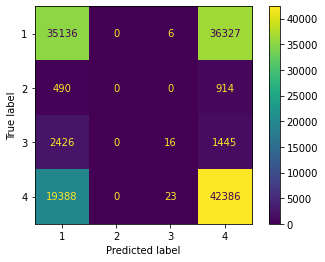

In [35]:
plot_confusion_matrix(dt, X_test, y_test)

In [36]:
bayes = CategoricalNB()
ohe = OneHotEncoder()
logreg = LinearSVC()
rf = RandomForestClassifier()
ovr = OneVsRestClassifier(logreg)

In [37]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171476 entries, 0 to 171475
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   CRASH_RECORD_ID     171476 non-null  object  
 1   TRAFFIC_DEVICE      171476 non-null  int64   
 2   BAD_WEATHER         171476 non-null  int64   
 3   BAD_VISIBILITY      171476 non-null  int64   
 4   BAD_TRAFFIC         171476 non-null  int64   
 5   BAD_ROAD_CONDITION  171476 non-null  int64   
 6   DEFECT_ROAD         171476 non-null  int64   
 7   Target1             171476 non-null  int64   
 8   NUM_PASSENGERS      171476 non-null  float64 
 9   MAKE                171476 non-null  object  
 10  MODEL               171476 non-null  object  
 11  VEHICLE_DEFECT      171476 non-null  object  
 12  CRASH_DATE          171476 non-null  object  
 13  AGE                 171476 non-null  float64 
 14  DRIVER_ACTION       171476 non-null  object  
 15  DRIVER_VISION    

In [84]:
dt = DecisionTreeClassifier(random_state = 1, max_depth=100)
X = main_df.drop(['Target1', 'CRASH_RECORD_ID'], axis=1)
y = main_df.Target1

X = ohe.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [85]:
ovr.fit(X_train, y_train)
dt.fit(X_train, y_train)
print('One vs Rest Score: {}'.format(ovr.score(X_train, y_train)))
print('Decision Tree Score: {}'.format(dt.score(X_train, y_train))) 

One vs Rest Score: 0.9814706820002022
Decision Tree Score: 0.810150302860653


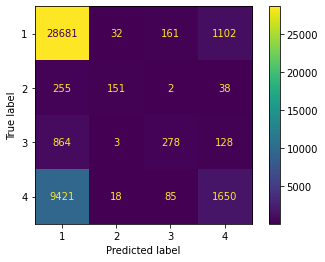

In [86]:
plot_confusion_matrix(dt, X_test, y_test);

In [2]:
# train_pred = ovr.predict(X_train)
# train_pred = label_binarize(train_pred, classes=len(main_df.Target1))
# y_test = label_binarize(y_test, classes=len(main_df.Target1))


In [ ]:
# roc_auc_score(y_train, train_pred, multi_class='ovo', average='macro')

In [72]:
X2 = main_df.drop(['Target1', 'CRASH_RECORD_ID', 'MAKE', 'MODEL', 'CRASH_DATE', 'AGE'], axis=1)
y2 = main_df.Target1

X2 = ohe.fit_transform(X2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 1)


In [ ]:
ovr.fit(X_train2, y_train2)
dt.fit(X_train2, y_train2)
print('One vs Rest Score: {}'.format(ovr.score(X_train2, y_train2)))
print('Decision Tree Score: {}'.format(dt.score(X_train2, y_train2))) 

# Piplines

In [87]:
pipeline_1 = Pipeline([('ss', StandardScaler()), 
                        ('RF', RandomForestClassifier(random_state = 1,  max_depth=100))])

In [88]:
grid = [{'RF__max_depth': [4, 5, 6], 
         'RF__min_samples_split': [0.1, 1.0, 10], 
         'RF__min_samples_leaf': [0.1, 0.5, 5]}]
GS = GridSearchCV(estimator=pipeline_1, 
                          param_grid=grid, 
                          scoring='precision', 
                          cv=5)

In [ ]:
#GS.fit()

In [ ]:
#GS.cv_results_

In [ ]:
#GS.best_estimator_.score()

In [ ]:
#GS.best_params_

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***